# ML Project Phase 3
*   21100157
*   21100320
*   21100297
*   21100130
*   21100260




# Downloading dataset and unzipping

In [1]:
# this is the updated data set with no validation data
!gdown --id 18qSvsM5W2QFASUlLWFPqxuYFPZcOs25b

Downloading...
From: https://drive.google.com/uc?id=18qSvsM5W2QFASUlLWFPqxuYFPZcOs25b
To: /content/LUMS_FALL2020_PROJECT_DATA1.zip
802MB [00:06, 129MB/s]


In [2]:
!unzip "LUMS_FALL2020_PROJECT_DATA1.zip" -d "ML Project Phase 3/"

Archive:  LUMS_FALL2020_PROJECT_DATA1.zip
   creating: ML Project Phase 3/Gender_Recognition/Test/
   creating: ML Project Phase 3/Gender_Recognition/Test/SPK083_M/
  inflating: ML Project Phase 3/Gender_Recognition/Test/SPK083_M/1.wav  
  inflating: ML Project Phase 3/Gender_Recognition/Test/SPK083_M/10.wav  
  inflating: ML Project Phase 3/Gender_Recognition/Test/SPK083_M/2.wav  
  inflating: ML Project Phase 3/Gender_Recognition/Test/SPK083_M/3.wav  
  inflating: ML Project Phase 3/Gender_Recognition/Test/SPK083_M/4.wav  
  inflating: ML Project Phase 3/Gender_Recognition/Test/SPK083_M/5.wav  
  inflating: ML Project Phase 3/Gender_Recognition/Test/SPK083_M/6.wav  
  inflating: ML Project Phase 3/Gender_Recognition/Test/SPK083_M/7.wav  
  inflating: ML Project Phase 3/Gender_Recognition/Test/SPK083_M/8.wav  
  inflating: ML Project Phase 3/Gender_Recognition/Test/SPK083_M/9.wav  
   creating: ML Project Phase 3/Gender_Recognition/Test/SPK084_M/
  inflating: ML Project Phase 3/Gender

# Imports

In [3]:
!pip install python_speech_features

import string
import numpy as np
import seaborn as sns
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import python_speech_features as mfcc
from scipy.io.wavfile import read

# common imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# part 1 imports
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# part 2 imports
from sklearn.svm import LinearSVC

# part 3 imports
from sklearn.naive_bayes import GaussianNB

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5887 sha256=8adfb236cb48dc8e1b5dc4a9af09ed10bb119737b1142fd30643bc1b5c9b817d
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


# Global helper functions

In [4]:
"""
returns mfcc vector (features) of wav file
features are 13 dimentional
"""

def get_MFCC(audio, sr):
    features = mfcc.mfcc(audio, sr, 0.025, 0.01, 13, appendEnergy = True)
    return np.mean(features, axis=0)

In [5]:
"""
Takes path of the directory i.e. path to train, test, or valid directory and returns features and labels in that directory as lists
"type" parameter in function is just to distinguish whether file reading is for gender or speaker recognition
"""

def readFiles(path, type):
  labels = [] # for speaker recognition, labels are speaker id i.e. SPK001 and for gender recognition, labels are gender i.e. male (M) or female (F)
  features = [] # wav files represented in MFCC vector
  subdirs = os.listdir(path) # this will return names of all the subdirectories in "path". Inside each of these subdirectories are the wav files that we will read
  for dir in subdirs: # iterating over all the subdirectories names present in "path"
    dirName = dir # will use to extract features
    dir = dir + "/"
    pathToRead = os.path.join(path, dir) # Now this path contains the wav files to be read as MFCCs vector
    wavFiles = os.listdir(pathToRead) # list of all the wav files in the current subdirectory of "path"
    if type == "speaker":
      label = dirName.split("_")[0] # e.g. if "SPK017_F" then splitting gives ["SPK017", "F"] and 0th index would be then label
    else:
      label = dirName.split("_")[1] # e.g. if "SPK017_F" then splitting gives ["SPK017", "F"] and 1st index would be then label
    for f in wavFiles: # iterating over the wav files in the current subdirectory of "path"
      currentWav = os.path.join(pathToRead, f) # current wav file to be read in that particular subdirectory of "path"
      sr, audio = read(currentWav)
      mfccVector = get_MFCC(audio, sr)
      labels.append(label)
      features.append(mfccVector) # this does not include bias right now
  return features, labels

# Preprocessing

In [6]:
# Returns dictionary with speaker training and test sets
def get_gender():
    genderTrainPath = "ML Project Phase 3/Gender_Recognition/Train/" # path containing folders of gender train data
    genderTestPath = "ML Project Phase 3/Gender_Recognition/Test/" # path containing folders of gender test data

    trainFeatures, trainLabels = readFiles(genderTrainPath, "gender") # reading train data (features) and labels 
    testFeatures, testLabels = readFiles(genderTestPath, "gender") # reading test data (features) and labels

    # visualizing length of lists to verify all files have been read
    print("(trainFeatures , trainLabels) = ({},{})".format(len(trainFeatures),len(trainLabels)))
    print("(testFeatures , testLabels) = ({},{})".format(len(testFeatures),len(testLabels)))

    # binary encoding the class labels
    trainLabelsEncoded, testLabelsEncoded = [], []

    for i in trainLabels:
      if i == 'F':
        trainLabelsEncoded.append(1)
      else:
        trainLabelsEncoded.append(0) # M

    for i in testLabels:
      if i == 'F':
        testLabelsEncoded.append(1)
      else:
        testLabelsEncoded.append(0)

    # Generate final arrays    
    trainFeatures = np.array(trainFeatures)
    testFeatures = np.array(testFeatures)

    # reshaping labels 
    trainLabels = np.array(trainLabels)
    testLabels = np.array(testLabels)

    trainLabels = trainLabels.reshape((len(trainLabels), -1))
    testLabels = testLabels.reshape((len(testLabels), -1))

    # reshaping binary encodings 
    trainLabelsEncoded = np.array(trainLabelsEncoded)
    testLabelsEncoded = np.array(testLabelsEncoded)
    
    trainLabelsEncoded = trainLabelsEncoded.reshape((len(trainLabelsEncoded), -1))
    testLabelsEncoded = testLabelsEncoded.reshape((len(testLabelsEncoded), -1))

    # visualizing shapes
    print('\nFeature shapes')
    print("trainFeatures = ",trainFeatures.shape)
    print("testFeatures = ",testFeatures.shape)
    print('\nLabels shapes')
    print("trainLabels = ",trainLabels.shape)
    print("testLabels = ",testLabels.shape)
    print('\nBinary encodings shapes')
    print("trainLabelsEncoded = ",trainLabelsEncoded.shape)
    print("testLabelsEncoded = ",testLabelsEncoded.shape)
    
    return {"trainFeatures":trainFeatures,"testFeatures":testFeatures,"trainLabels":trainLabels,"testLabels":testLabels,"trainLabelsEncoded":trainLabelsEncoded,"testLabelsEncoded":testLabelsEncoded}

# Encoding for speaker labels
def EncodeSpeaker(labels):
  encoded = []
  for i in range(len(labels)):
    if labels[i][3:5] == '00': # e.g if ids are 001, 002, etc
      id = labels[i][-1]
      encoded.append(int(id) - 1)
    elif labels[i][3:4] == '0' and labels[i][4:5] != '0': # e.g if ids are 011, 022, etc
      id = labels[i][4:6]
      encoded.append(int(id) - 1)
    elif labels[i][3:4] != '0': # e.g if ids are 129, 112, etc
      id = labels[i][3:6]
      encoded.append(int(id) - 1)
  return encoded

# Returns dictionary with speaker training and test sets
def get_speaker():
    # paths
    speakerTrainPath = "ML Project Phase 3/Speaker_Recognition/Train/" # path containing folders of speaker train data
    speakerTestPath = "ML Project Phase 3/Speaker_Recognition/Test/" # path containing folders of speaker test data

    trainFeatures, trainLabels = readFiles(speakerTrainPath, "speaker") # reading train data (features) and labels 
    testFeatures, testLabels = readFiles(speakerTestPath, "speaker") # reading test data (features) and labels

    # visualizing length of lists to verify all files have been read
    print(len(trainFeatures))
    print(len(testFeatures))
    print('')
    print(len(trainLabels))
    print(len(testLabels))

    # encoding the class labels
    """
    Function to encode the speaker labels
    labels -> train, or test labels
    returns : list of encodings
    """

    #e.g. SPK112_M
    # index 3-5:  112, stored at 111 (index-1)
    # 142 classes

    # encoding now
    trainLabelsEncoded, testLabelsEncoded = [], []
    trainLabelsEncoded = EncodeSpeaker(trainLabels)
    testLabelsEncoded = EncodeSpeaker(testLabels)

    # converting to numpy arrays
    trainLabelsEncoded = np.array(trainLabelsEncoded)
    testLabelsEncoded = np.array(testLabelsEncoded)

    # converting to numpy arrays
    trainFeatures = np.array(trainFeatures)
    testFeatures = np.array(testFeatures)

    trainLabels = np.array(trainLabels)
    testLabels = np.array(testLabels)

    # reshaping labels 
    trainLabels = trainLabels.reshape((len(trainLabels), -1))
    testLabels = testLabels.reshape((len(testLabels), -1))

    # reshaping labels enodings 
    trainLabelsEncoded = trainLabelsEncoded.reshape((len(trainLabelsEncoded), -1))
    testLabelsEncoded = testLabelsEncoded.reshape((len(testLabelsEncoded), -1))

    # visualizing shapes
    print('Feature shapes')
    print("trainFeatures = ",trainFeatures.shape)
    print("testFeatures = ",testFeatures.shape)
    print('')
    print('Labels shapes')
    print("trainLabels = ",trainLabels.shape)
    print("testLabels = ",testLabels.shape)
    print('')
    print('labels encodings shapes')
    print("trainLabelsEncoded = ",trainLabelsEncoded.shape)
    print("testLablesEncoded = ",testLabelsEncoded.shape)
    
    return {"trainFeatures":trainFeatures,"testFeatures":testFeatures,"trainLabels":trainLabels,"testLabels":testLabels,"trainLabelsEncoded":trainLabelsEncoded,"testLabelsEncoded":testLabelsEncoded}


Saving the read files into separate dictionaries

In [7]:
gender_data = get_gender()

(trainFeatures , trainLabels) = (1250,1250)
(testFeatures , testLabels) = (170,170)

Feature shapes
trainFeatures =  (1250, 13)
testFeatures =  (170, 13)

Labels shapes
trainLabels =  (1250, 1)
testLabels =  (170, 1)

Binary encodings shapes
trainLabelsEncoded =  (1250, 1)
testLabelsEncoded =  (170, 1)


In [8]:
speaker_data = get_speaker()

1136
284

1136
284
Feature shapes
trainFeatures =  (1136, 13)
testFeatures =  (284, 13)

Labels shapes
trainLabels =  (1136, 1)
testLabels =  (284, 1)

labels encodings shapes
trainLabelsEncoded =  (1136, 1)
testLablesEncoded =  (284, 1)


# Part 1: Multilayer Perceptron

In [9]:
## Part 1

"""
This function trains and predicts and then outputs the accuracy metrics using multi-layer perceptron
xtrain, xtest -> training data of shape m x k where m are total samples and k are number of features i.e. k would be 14 for gender and speaker recognition
ytrain, ytest -> labels in encoded form (not one-hot encoded) of shape m x 1 where m are total number of samples
lr -> learning rate
layerSize -> tuple containing hidden layer sizes. Can be of form (a, b) or (a)
"""

def part1(xtrain, ytrain, xtest, ytest, lrs, layerSizes):
    params = {"learning_rate_init":lrs,"hidden_layer_sizes":layerSizes}
    
    clf = MLPClassifier(random_state=1, max_iter=5000, activation='logistic', solver='sgd')

    grid_clf = GridSearchCV(clf, params,scoring="f1_macro",cv=3)
    grid_clf.fit(xtrain, ytrain)
    print("Best score was {} for params = {}".format(grid_clf.best_score_,grid_clf.best_params_))
    pred = grid_clf.predict(xtest)
    score = grid_clf.score(xtest, ytest)

    # accuracy score on test set
    acc = accuracy_score(ytest, pred)

    # classification report on test set
    report = classification_report(ytest, pred, output_dict=True)

    # confusion matrix on test set
    confusionmatrix = confusion_matrix(ytest, pred)

    print('Accuracy metrics on test set are as follows')
    print('')
    print('Model score: ', round(score * 100, 2), '%')
    print('Accuracy: ', round(acc * 100, 2), '%')
    print('Macro-precision: ', round(report['macro avg']['precision'] * 100, 2), '%')
    print('Macro-recall: ', round(report['macro avg']['recall'] * 100, 2), '%')
    print('Macro-f1: ', round(report['macro avg']['f1-score'] * 100, 2), '%')
    print('')
    print('Confusion matrix on test set')
    if (confusionmatrix.shape[0] > 5):
        plt.figure(figsize= (40,35))
    else:
        plt.figure(figsize=(8,5))
    ax = sns.heatmap(confusionmatrix,annot=True,fmt=".0f")
    title = "Confusion matrix"
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

We will run the part 1 code for each combination of learning_rate_init and hidden_layer_sizes for both gender recognition and speaker recognition

Best score was 0.7858577977703902 for params = {'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.4}
Accuracy metrics on test set are as follows

Model score:  82.37 %
Accuracy:  87.65 %
Macro-precision:  83.33 %
Macro-recall:  81.54 %
Macro-f1:  82.37 %

Confusion matrix on test set


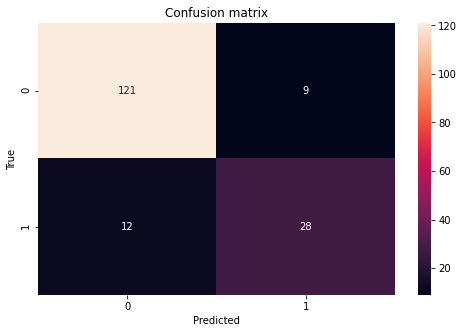

In [10]:
#Gender Recognition
lr_inits = [0.4,0.1,0.01]
hl_sizes = [(128,64),(64,),(64,32),(32,)]

part1(gender_data["trainFeatures"],gender_data["trainLabelsEncoded"],gender_data["testFeatures"],gender_data["testLabelsEncoded"],lr_inits,hl_sizes)

Best score was 0.9059747373127655 for params = {'hidden_layer_sizes': (64,), 'learning_rate_init': 0.1}
Accuracy metrics on test set are as follows

Model score:  93.19 %
Accuracy:  93.66 %
Macro-precision:  95.07 %
Macro-recall:  93.66 %
Macro-f1:  93.19 %

Confusion matrix on test set


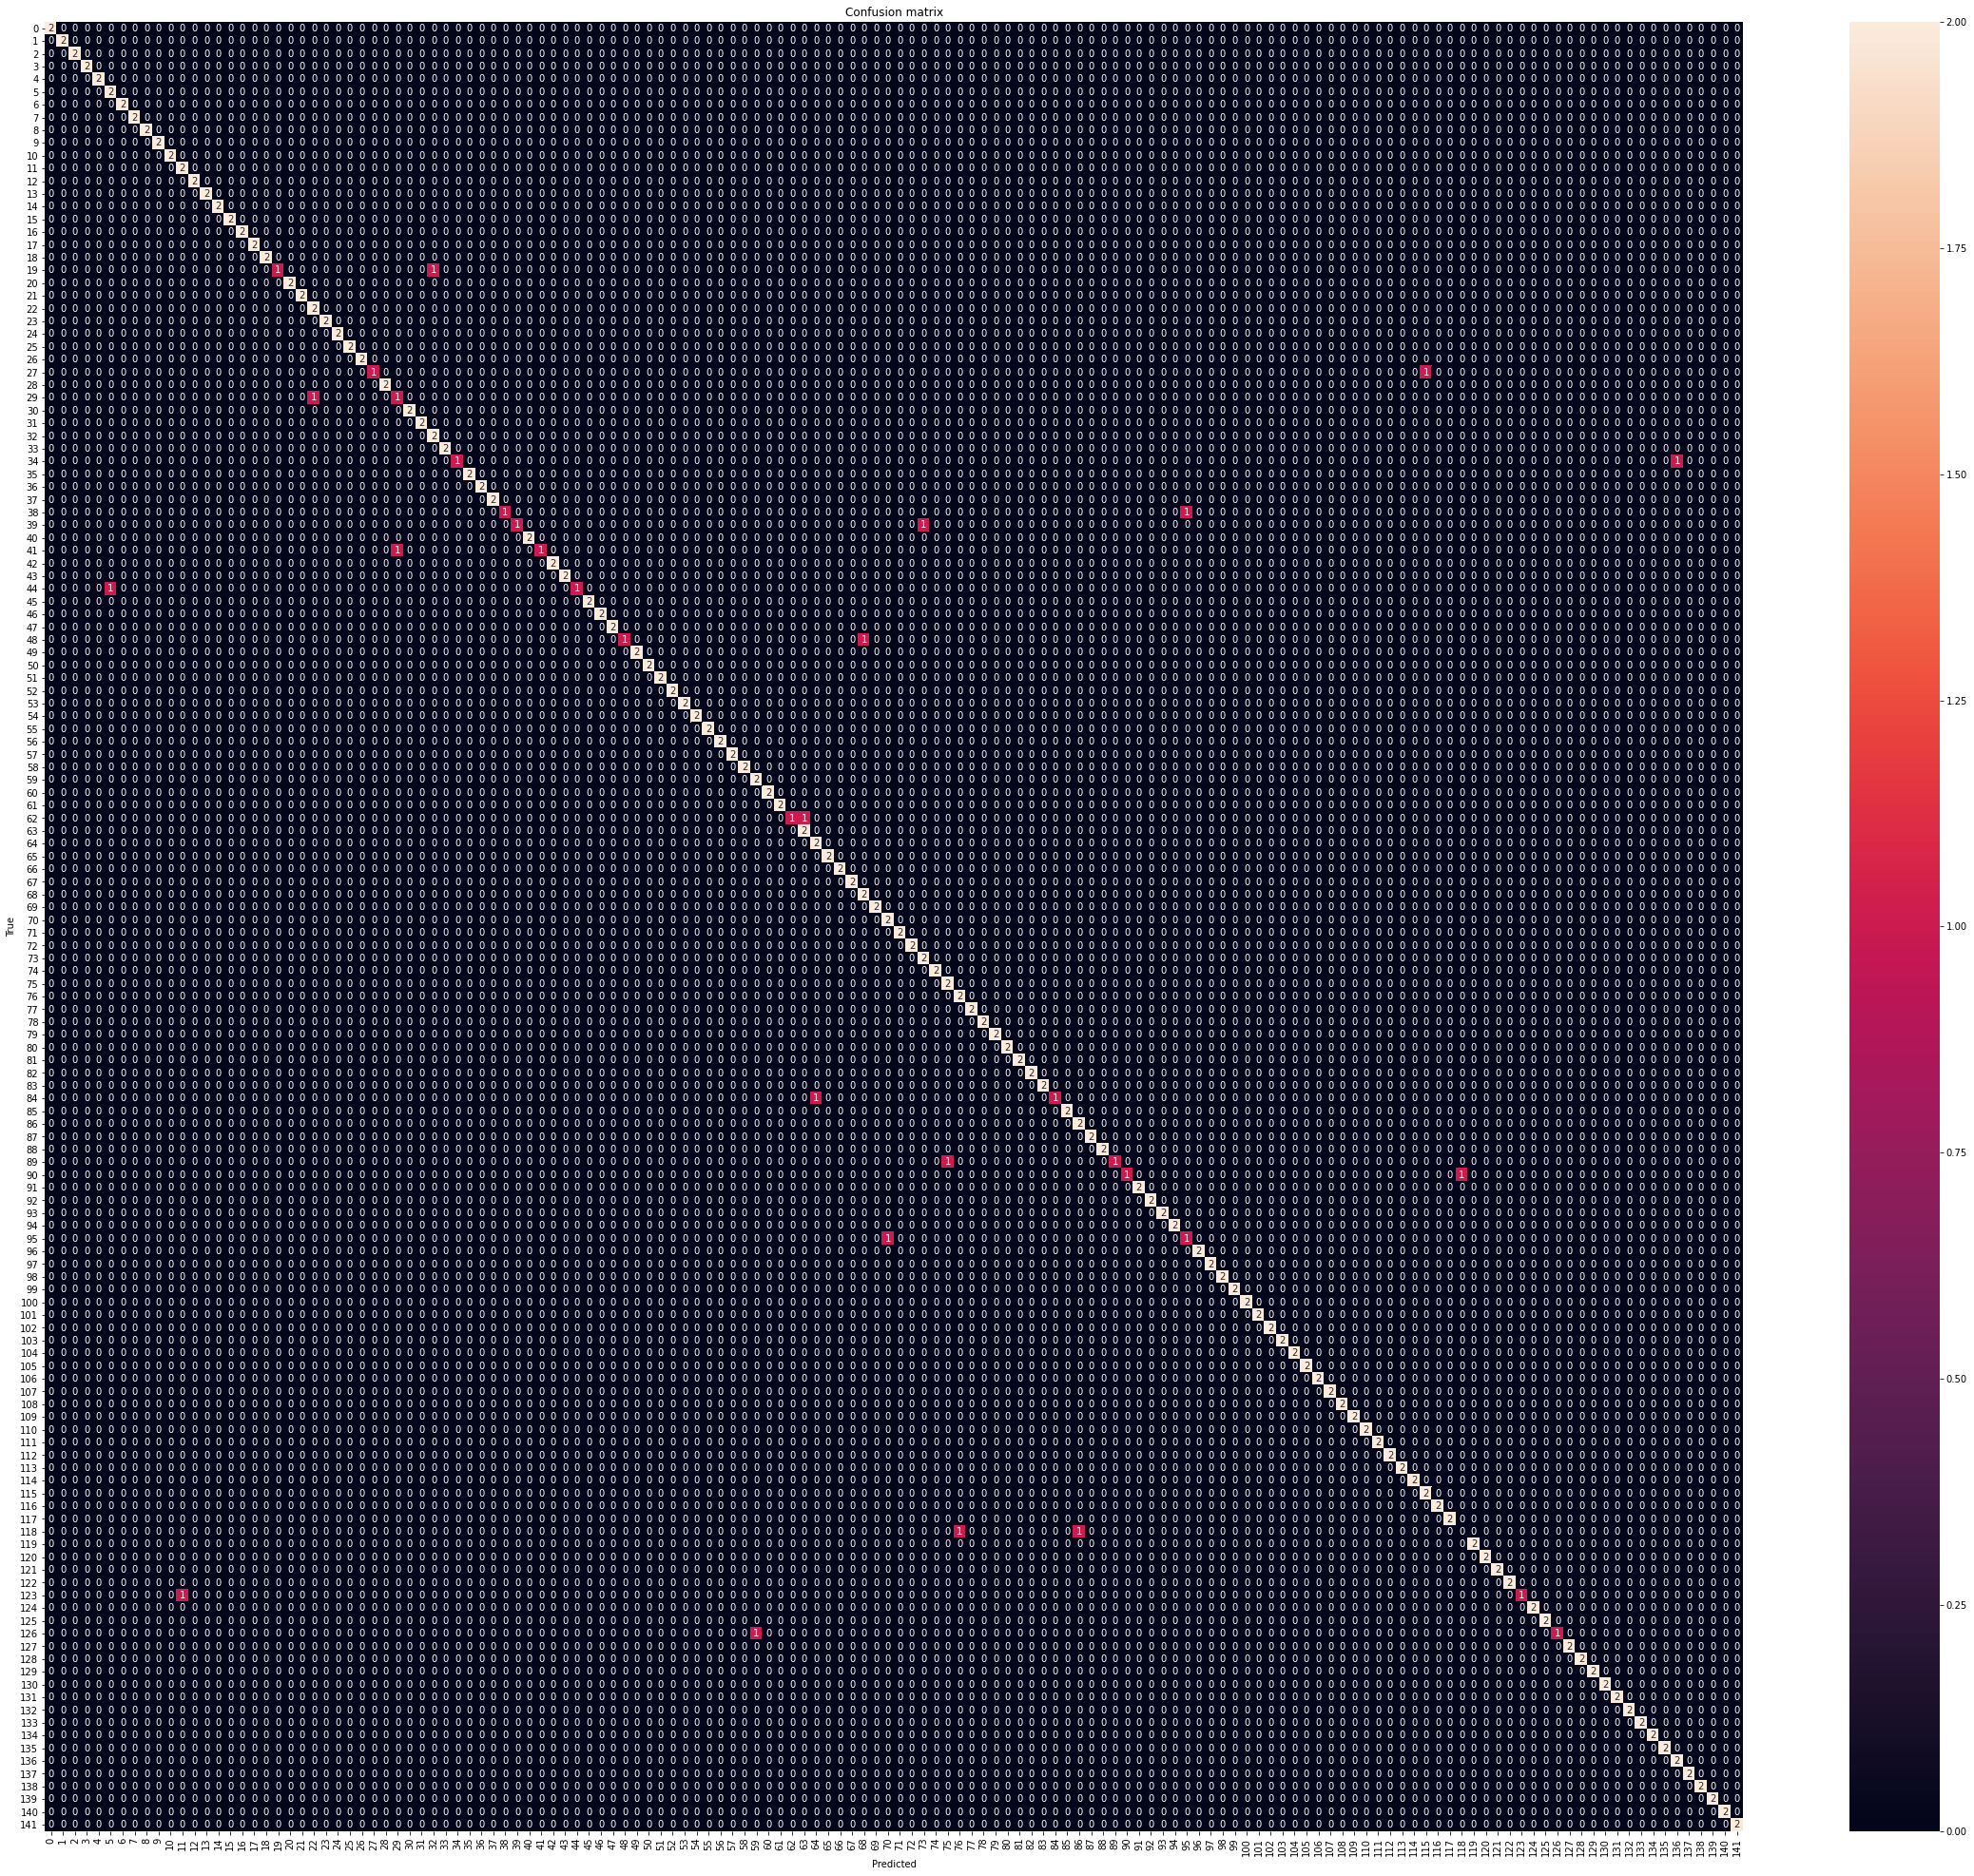

In [11]:
#Speaker Recognition
part1(speaker_data["trainFeatures"],speaker_data["trainLabelsEncoded"],speaker_data["testFeatures"],speaker_data["testLabelsEncoded"],lr_inits,hl_sizes)

# Part 2: Linear Support Vectors

In [12]:
"""
This function trains and predicts and then outputs the accuracy metrics using linear support vector
xtrain, xtest -> training data of shape m x k where m are total samples and k are number of features i.e. k would be 14 for gender and speaker recognition
ytrain, ytest -> labels in encoded form (not one-hot encoded) of shape m x 1 where m are total number of samples
"""

def part2(xtrain, ytrain, xtest, ytest):
  clf = LinearSVC(dual=False).fit(xtrain, ytrain)
  pred = clf.predict(xtest)
  score = clf.score(xtest, ytest)

  # accuracy score on test set
  acc = accuracy_score(ytest, pred)

  # classification report on test set
  report = classification_report(ytest, pred, output_dict=True)

  # confusion matrix on test set
  confusionmatrix = confusion_matrix(ytest, pred)

  print('Accuracy metrics on test set are as follows')
  print('')
  print('Model score: ', round(score * 100, 2), '%')
  print('Accuracy: ', round(acc * 100, 2), '%')
  print('Macro-precision: ', round(report['macro avg']['precision'] * 100, 2), '%')
  print('Macro-recall: ', round(report['macro avg']['recall'] * 100, 2), '%')
  print('Macro-f1: ', round(report['macro avg']['f1-score'] * 100, 2), '%')
  print('')
  print('Confusion matrix on test set')
  if (confusionmatrix.shape[0] > 5):
    plt.figure(figsize= (40,35))
  else:
    plt.figure(figsize=(8,5))
  ax = sns.heatmap(confusionmatrix,annot=True,fmt=".0f")
  title = "Confusion matrix"
  plt.title(title)
  plt.xlabel('Predicted')
  plt.ylabel('True')

Accuracy metrics on test set are as follows

Model score:  83.53 %
Accuracy:  83.53 %
Macro-precision:  77.85 %
Macro-recall:  73.65 %
Macro-f1:  75.33 %

Confusion matrix on test set


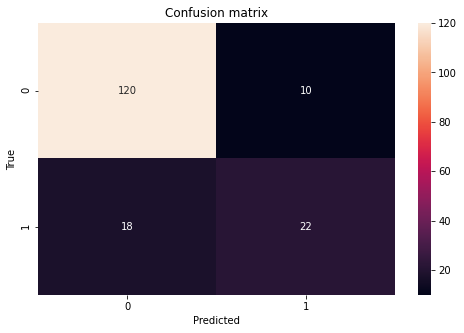

In [13]:
#Gender Recognition
part2(gender_data["trainFeatures"],gender_data["trainLabelsEncoded"],gender_data["testFeatures"],gender_data["testLabelsEncoded"])

Accuracy metrics on test set are as follows

Model score:  84.15 %
Accuracy:  84.15 %
Macro-precision:  87.32 %
Macro-recall:  84.15 %
Macro-f1:  83.19 %

Confusion matrix on test set


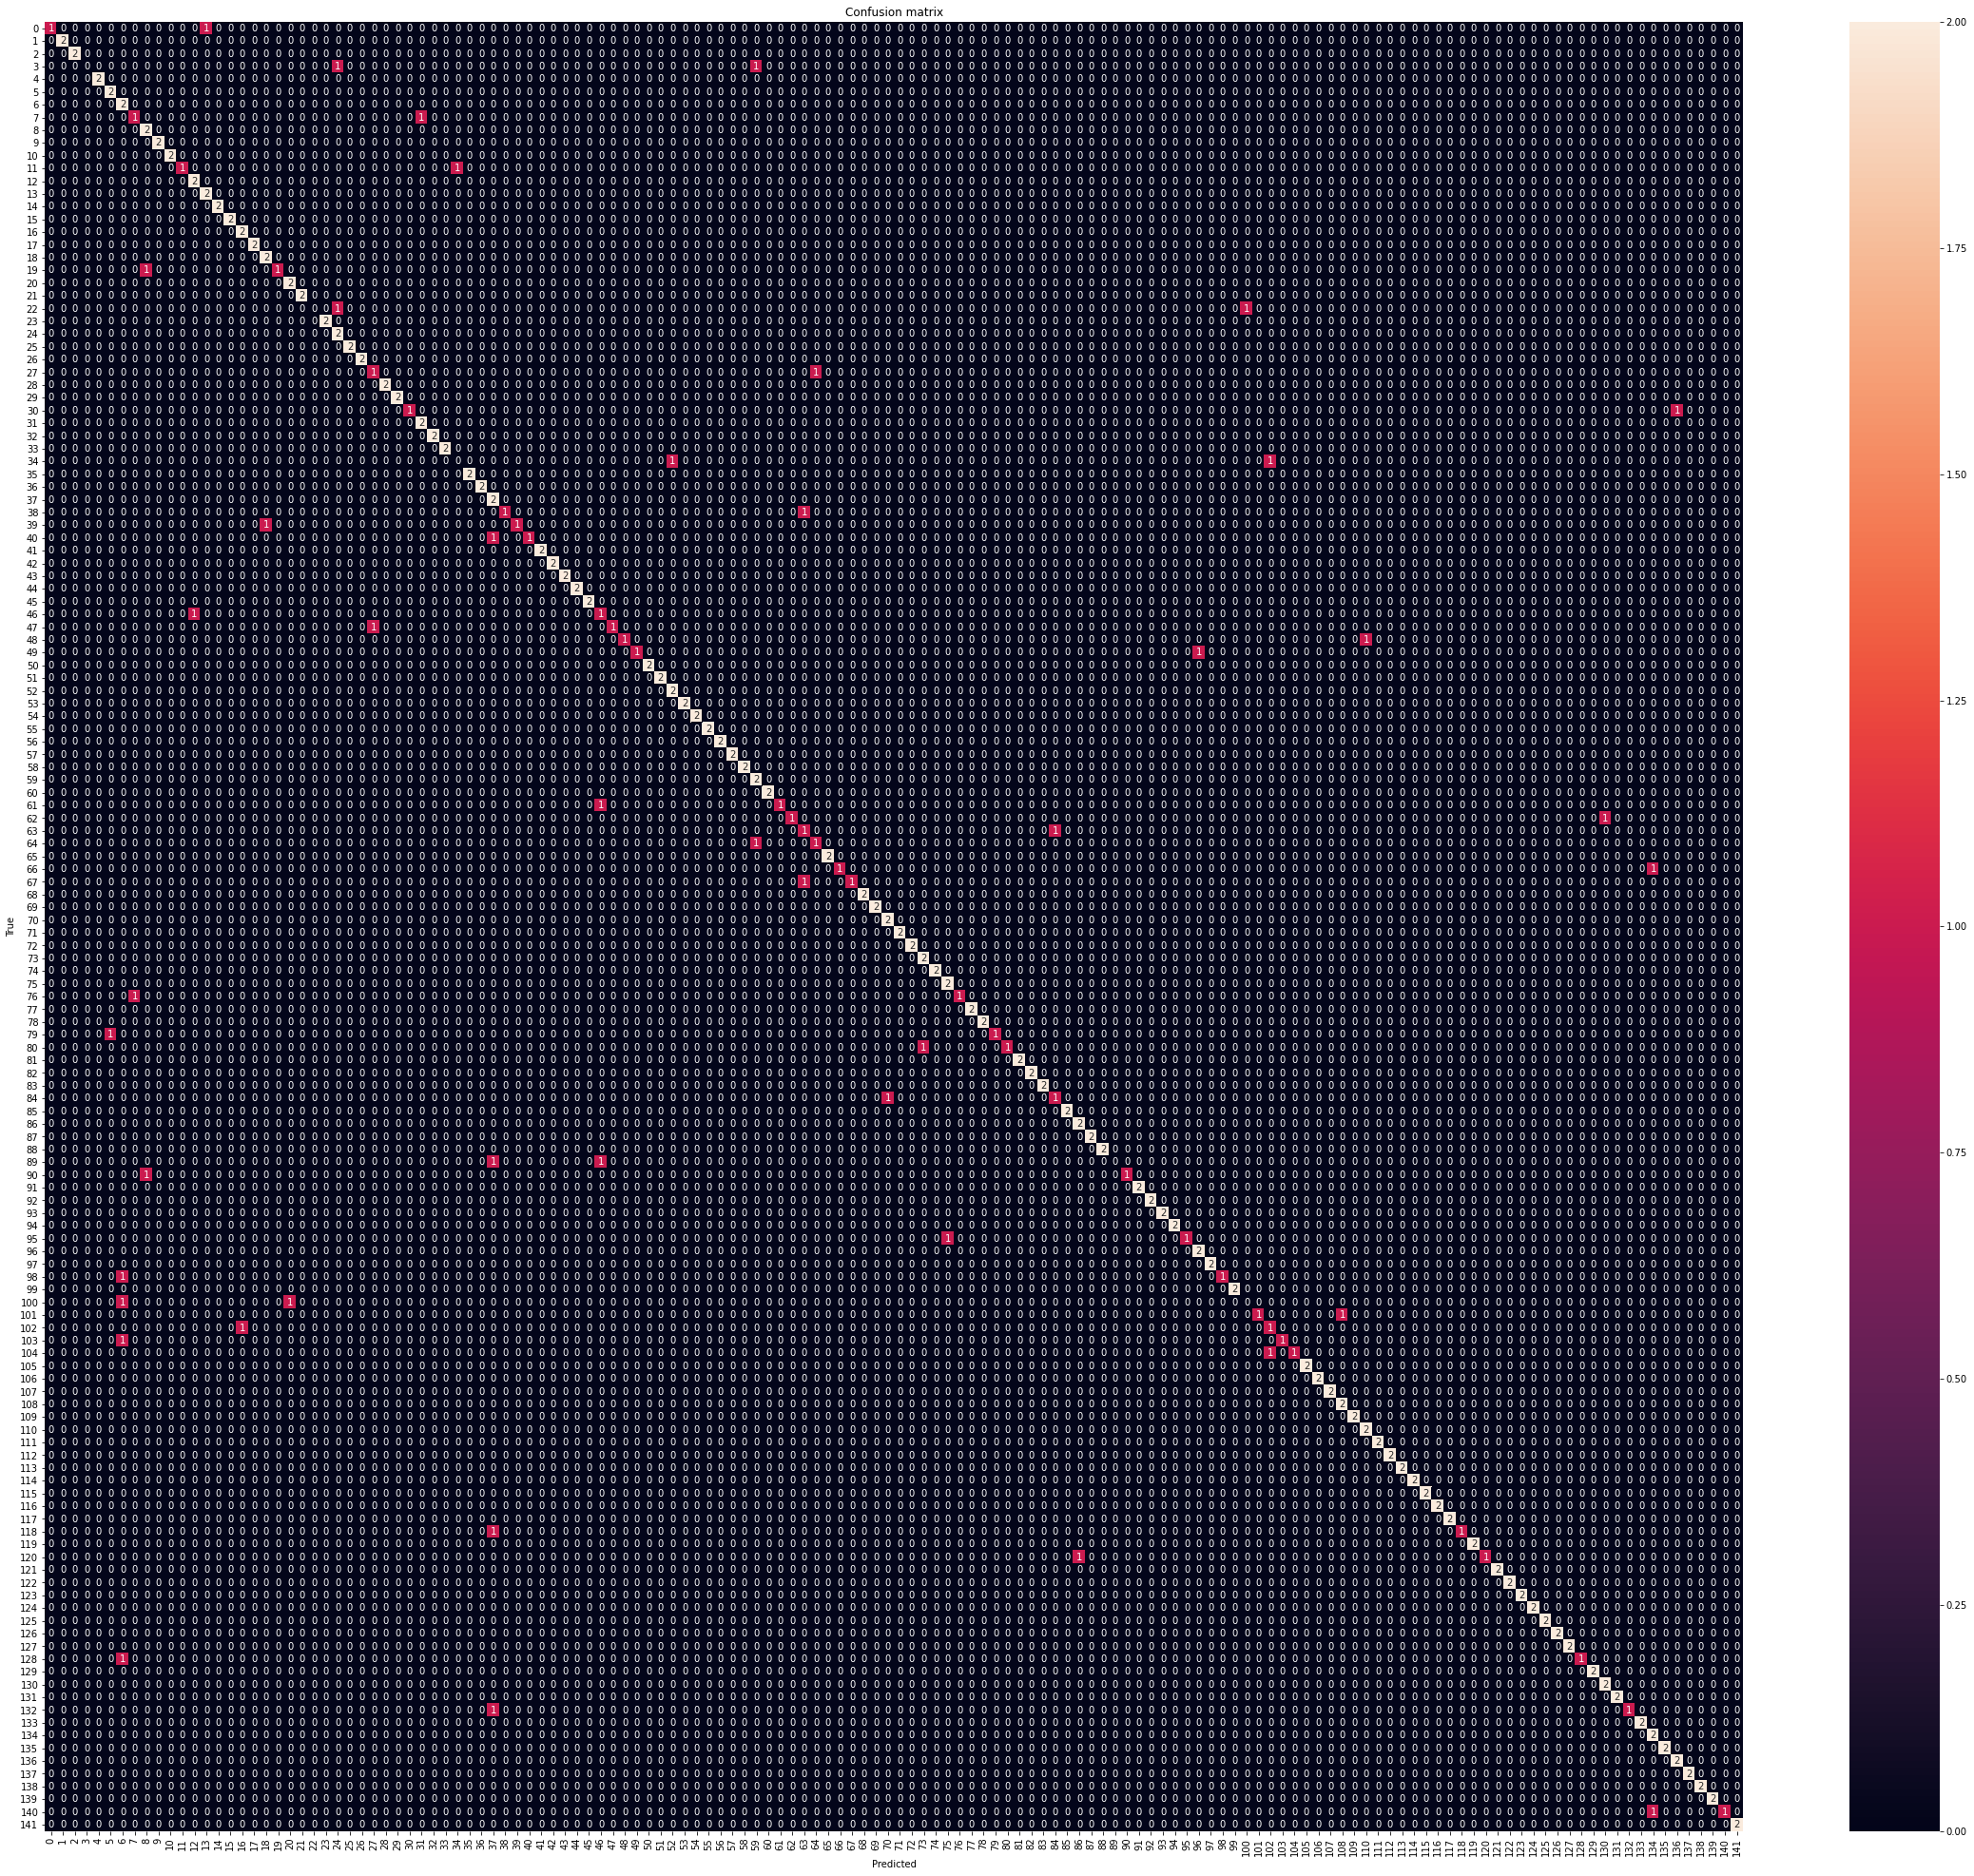

In [14]:
#Speaker Recognition
part2(speaker_data["trainFeatures"],speaker_data["trainLabelsEncoded"],speaker_data["testFeatures"],speaker_data["testLabelsEncoded"])

# Part 3: Gaussian Naive Bayes

In [15]:
"""
This function trains and predicts and then outputs the accuracy metrics using Gausian naive bayes
xtrain, xtest -> training data of shape m x k where m are total samples and k are number of features i.e. k would be 14 for gender and speaker recognition
ytrain, ytest -> labels in encoded form (not one-hot encoded) of shape m x 1 where m are total number of samples
"""

def part3(xtrain, ytrain, xtest, ytest):
  clf = GaussianNB(var_smoothing=0.09).fit(xtrain, ytrain)
  pred = clf.predict(xtest)
  score = clf.score(xtest, ytest)

  # accuracy score on test set
  acc = accuracy_score(ytest, pred)

  # classification report on test set
  report = classification_report(ytest, pred, output_dict=True)

  # confusion matrix on test set
  confusionmatrix = confusion_matrix(ytest, pred)
  
  print('Accuracy metrics on test set are as follows')
  print('')
  print('Model score: ', round(score * 100, 2), '%')
  print('Accuracy: ', round(acc * 100, 2), '%')
  print('Macro-precision: ', round(report['macro avg']['precision'] * 100, 2), '%')
  print('Macro-recall: ', round(report['macro avg']['recall'] * 100, 2), '%')
  print('Macro-f1: ', round(report['macro avg']['f1-score'] * 100, 2), '%')
  print('')
  print('Confusion matrix on test set')

  if (confusionmatrix.shape[0] > 5):
    plt.figure(figsize= (40,35))
  else:
    plt.figure(figsize=(8,5))
  ax = sns.heatmap(confusionmatrix,annot=True,fmt=".0f")
  title = "Confusion matrix"
  plt.title(title)
  plt.xlabel('Predicted')
  plt.ylabel('True')

Accuracy metrics on test set are as follows

Model score:  87.06 %
Accuracy:  87.06 %
Macro-precision:  82.3 %
Macro-recall:  81.15 %
Macro-f1:  81.7 %

Confusion matrix on test set


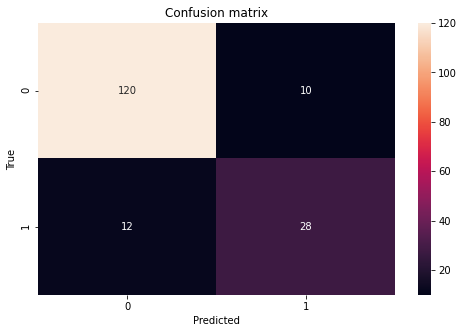

In [16]:
part3(gender_data["trainFeatures"],gender_data["trainLabelsEncoded"],gender_data["testFeatures"],gender_data["testLabelsEncoded"])

Accuracy metrics on test set are as follows

Model score:  96.13 %
Accuracy:  96.13 %
Macro-precision:  97.42 %
Macro-recall:  96.13 %
Macro-f1:  95.87 %

Confusion matrix on test set


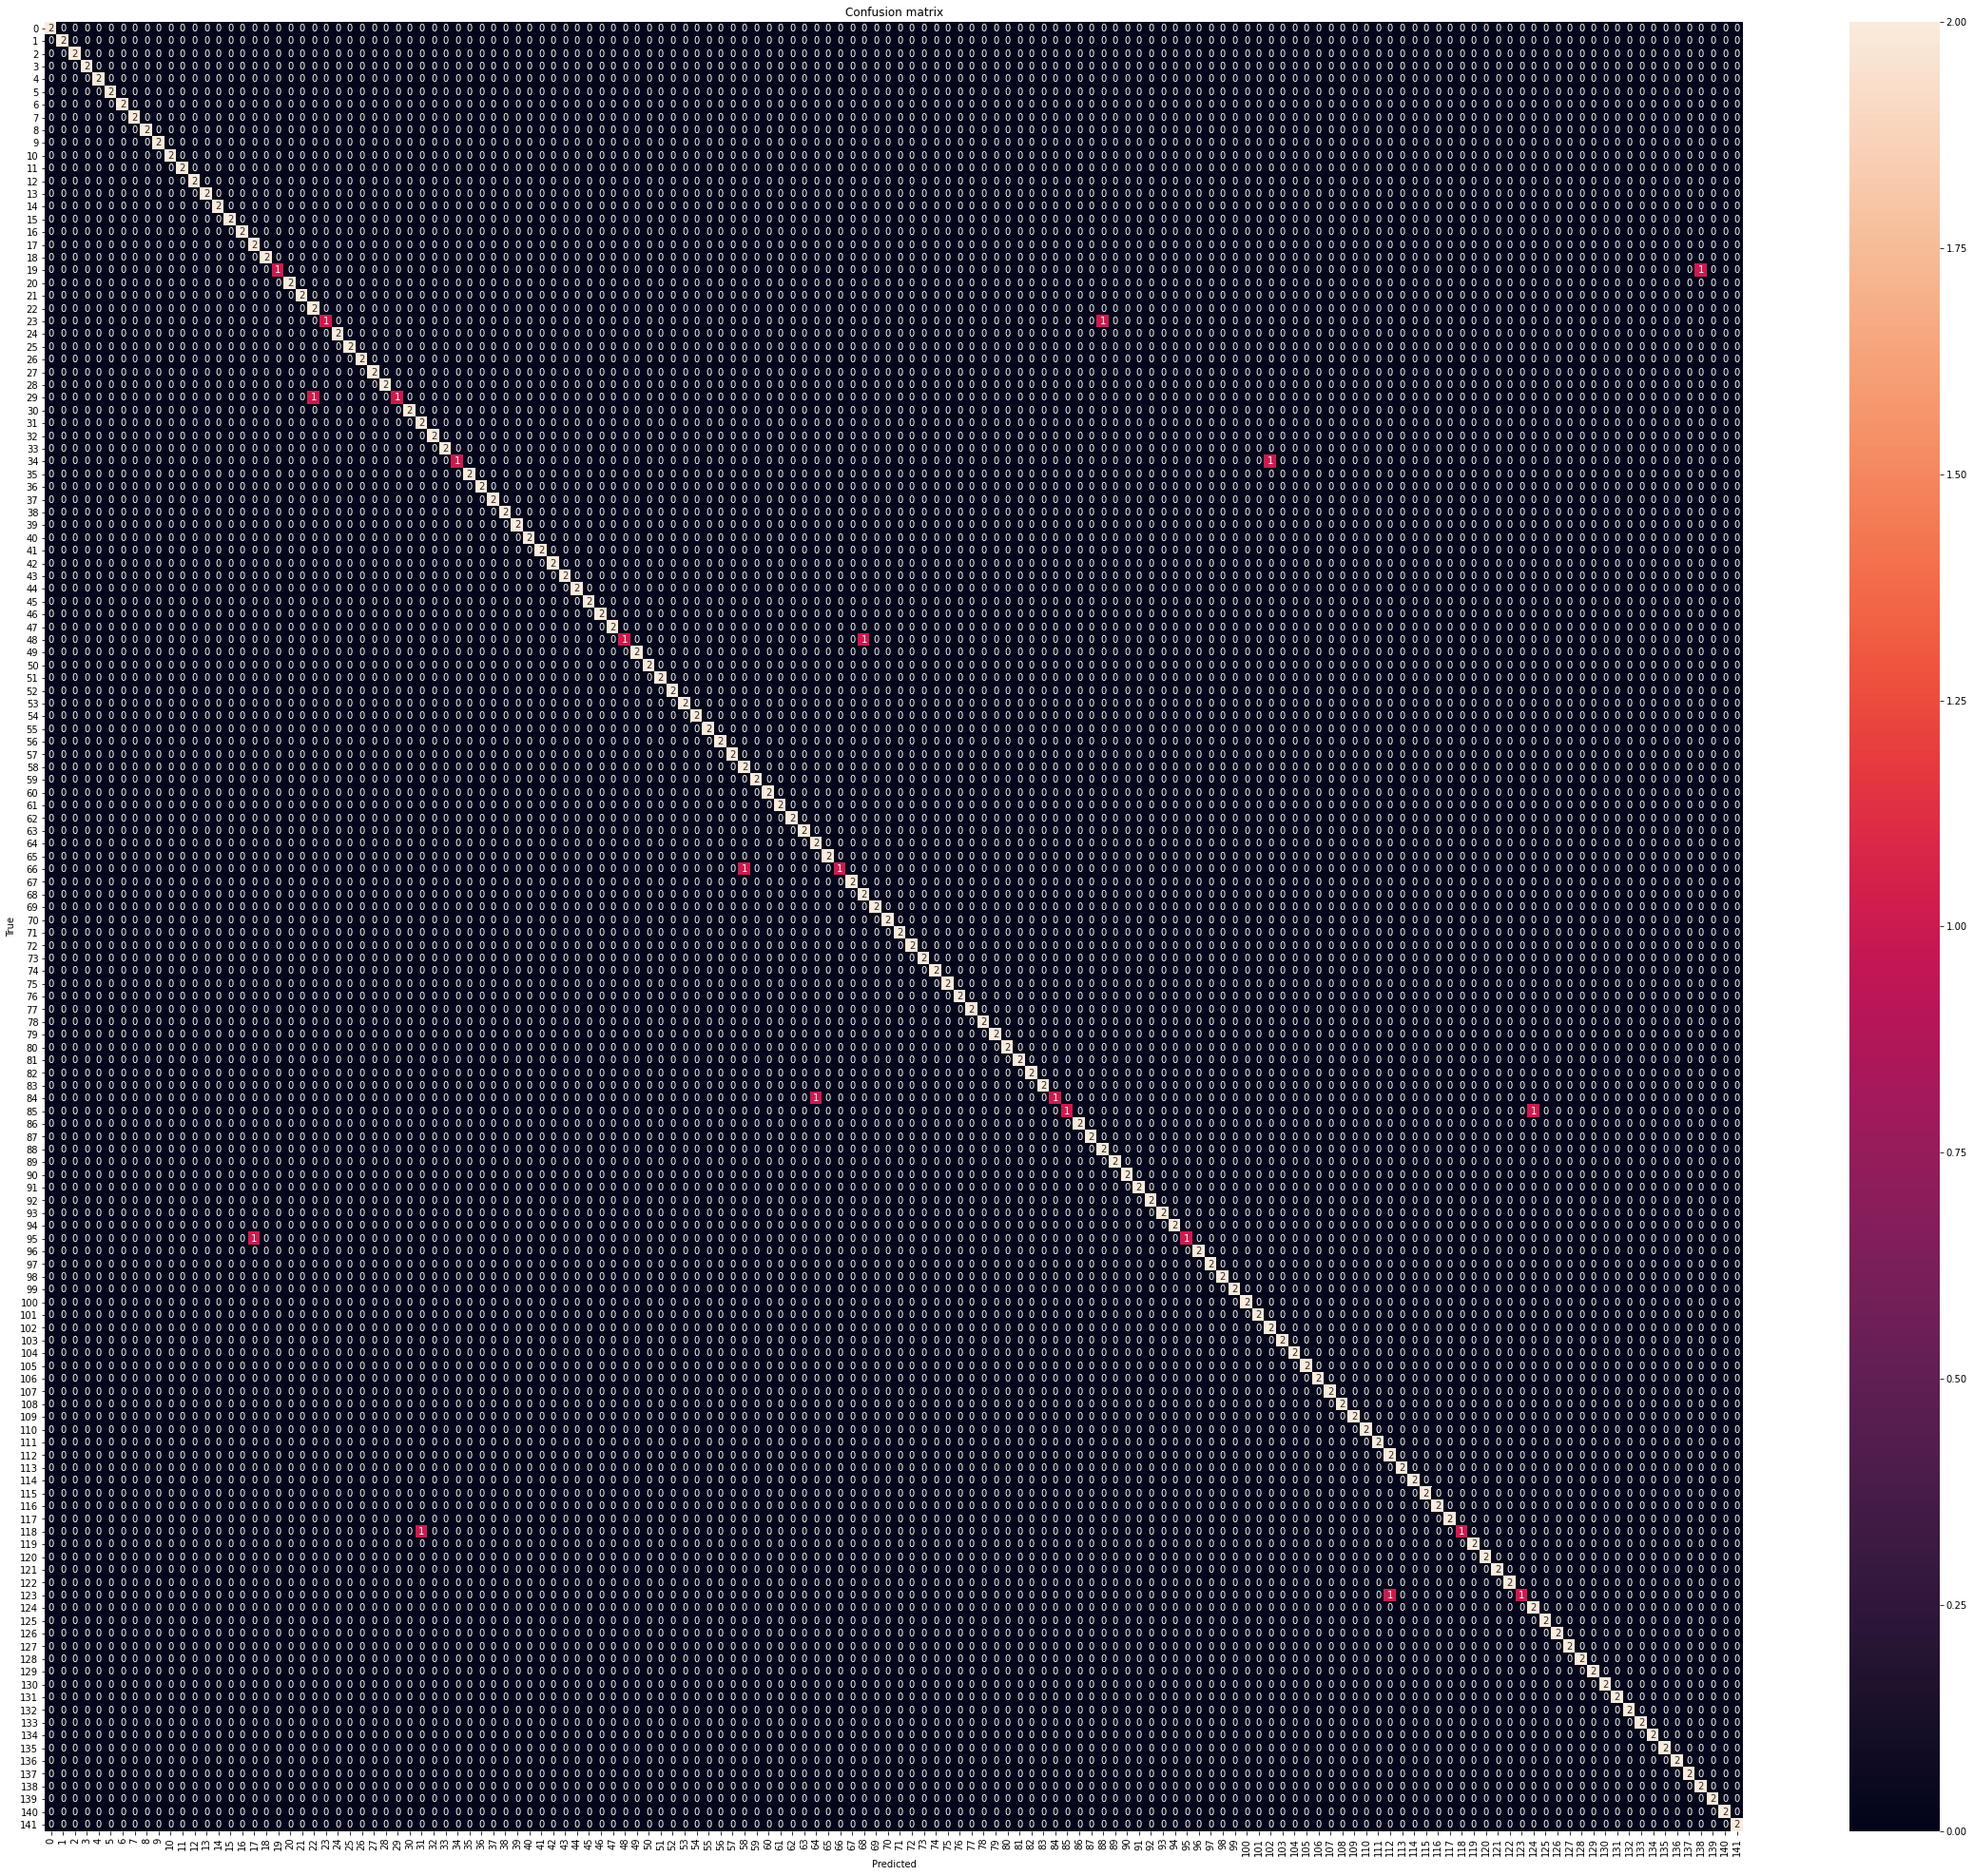

In [17]:
#Speaker Recognition
part3(speaker_data["trainFeatures"],speaker_data["trainLabelsEncoded"],speaker_data["testFeatures"],speaker_data["testLabelsEncoded"])